## 📦 UrbanSound8K - Environmental Sound Classification

### 🎯 Project Objective

To develop and deploy an end-to-end machine learning system that classifies environmental sounds using the UrbanSound8K dataset. The system supports prediction, retraining, metric logging, database integration, and load testing simulation using Locust.

---

## 🧠 Problem Solved

Detecting and classifying urban sounds such as sirens, dog barks, or engine idling is crucial in today’s smart cities. These sounds are often indicators of important events or potential hazards. For example, real-time detection of sirens can help emergency response systems prioritize tasks, while recognizing engine idling or dog barks can assist in monitoring traffic flow or ensuring public safety.

This project uses machine learning to automate the classification of these sounds, enabling more efficient surveillance, accessibility services, and urban noise management. By doing so, it supports smarter, more responsive environments—whether for enhancing public safety, improving accessibility for people with disabilities, or mapping noise pollution in urban spaces.

link to [dataset](https://urbansounddataset.weebly.com/download-urbansound8k.html)

In [18]:
# Cell 1: Imports
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import warnings
warnings.filterwarnings("ignore")
import psycopg2
from urllib.parse import urlparse
from datetime import datetime



In [2]:
# Cell 2: Load Metadata
metadata_path = '../data/metadata/UrbanSound8K.csv'
metadata = pd.read_csv(metadata_path)
metadata


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


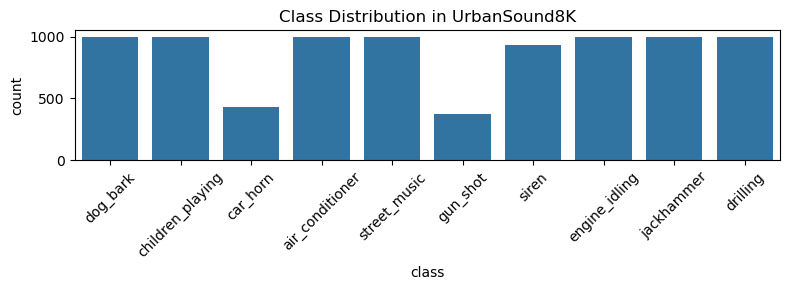

In [3]:
# Cell 3: Visualize Class Distribution
plt.figure(figsize=(8, 3))
sns.countplot(x='class', data=metadata)
plt.xticks(rotation=45)
plt.title("Class Distribution in UrbanSound8K")
plt.tight_layout()
plt.show()

# waveform visualization
def plot_waveform(file_path):
    y, sr = librosa.load(file_path, sr=None)
    plt.figure(figsize=(5, 2))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform of {os.path.basename(file_path)}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()
    
# spectrogram visualization
def plot_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.figure(figsize=(5, 2))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram of {os.path.basename(file_path)}")
    plt.tight_layout()
    plt.show()      

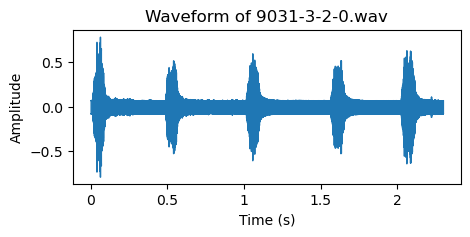

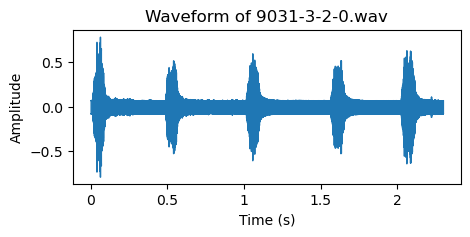

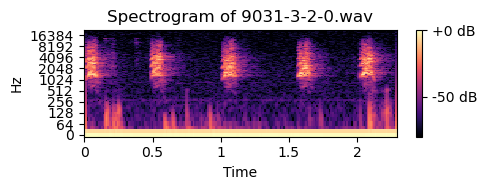

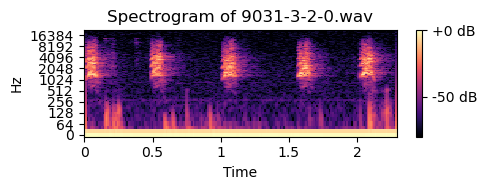

In [4]:
plot_waveform('../data/audio/fold1/9031-3-2-0.wav')
plot_waveform('../data/audio/fold1/9031-3-2-0.wav')
plot_spectrogram('../data/audio/fold1/9031-3-2-0.wav')
plot_spectrogram('../data/audio/fold1/9031-3-2-0.wav')

In [5]:
# Cell 4: Extract Features (MFCCs)
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    return mfccs_scaled

In [6]:
# Cell 5: Feature Engineering Loop (process all folds)
features = []
for i, row in metadata.iterrows():
    file_path = f"../data/audio/fold{row['fold']}/{row['slice_file_name']}"
    label = row['class']
    try:
        mfccs = extract_features(file_path)
        features.append([mfccs, label])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

In [7]:
# Cell 6: Prepare Dataset
features_df = pd.DataFrame(features, columns=['feature', 'label'])

# Initialize and fit the label encoder
label_encoder = LabelEncoder()
X = np.array(features_df['feature'].tolist())
y = label_encoder.fit_transform(features_df['label'])

# Get the class names in correct order
class_names = list(label_encoder.classes_)

In [8]:
# Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to DataFrames for saving
df_X_train = pd.DataFrame(X_train)
df_X_test = pd.DataFrame(X_test)
df_y_train = pd.DataFrame(y_train, columns=['label'])
df_y_test = pd.DataFrame(y_test, columns=['label'])

# Save to CSV files
df_X_train.to_csv("../models/X_train.csv", index=False)
df_X_test.to_csv("../models/X_test.csv", index=False)
df_y_train.to_csv("../models/y_train.csv", index=False)
df_y_test.to_csv("../models/y_test.csv", index=False)

In [9]:
# Cell 8: Train Model
model = RandomForestClassifier(n_estimators=100, random_state=32)
model.fit(X_train, y_train)

# Save all artifacts
joblib.dump(model, '../models/urbansound_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
joblib.dump(label_encoder, '../models/label_encoder.pkl')

# Additionally save class names as text file for reference
with open('../models/class_names.txt', 'w') as f:
    f.write('\n'.join(class_names))


🔍 Accuracy: 0.8975

 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       203
           1       0.97      0.83      0.89        86
           2       0.78      0.89      0.83       183
           3       0.85      0.85      0.85       201
           4       0.90      0.84      0.87       206
           5       0.93      0.99      0.96       193
           6       0.98      0.78      0.87        72
           7       0.93      0.95      0.94       208
           8       0.93      0.97      0.95       165
           9       0.88      0.83      0.86       230

    accuracy                           0.90      1747
   macro avg       0.91      0.89      0.90      1747
weighted avg       0.90      0.90      0.90      1747



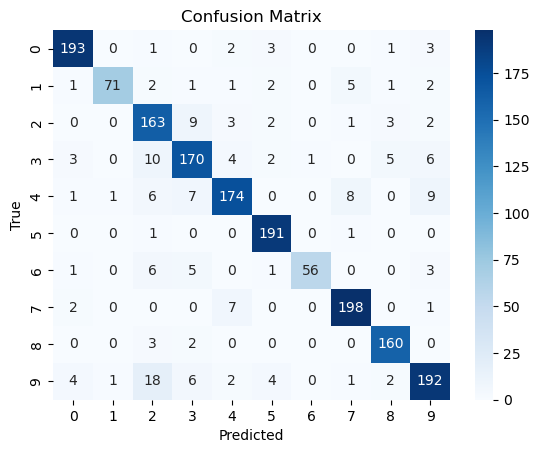

 Connected to PostgreSQL successfully.
 Results successfully saved to database at 2025-08-03 02:07:35.314471.
 Database connection closed.


In [ ]:
# Cell 9: Evaluate Model and Save Results to PostgreSQL
import traceback

from dotenv import load_dotenv
import os

load_dotenv()  # Load variables from .env file
db_url = os.getenv("DATABASE_URL")

if not db_url:
    raise EnvironmentError("DATABASE_URL is not set.")

# Parse database URL
result = urlparse(db_url)
username = result.username
password = result.password
database = result.path[1:]  # removes leading '/'
hostname = result.hostname
port = result.port

# Evaluate the trained model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation results
print(f"\n🔍 Accuracy: {accuracy:.4f}\n")
print(" Classification Report:\n", classification_rep)

# Plot and show confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Prepare metrics for saving
report_dict = classification_report(y_test, y_pred, output_dict=True)
precision = report_dict['weighted avg']['precision']
recall = report_dict['weighted avg']['recall']
f1 = report_dict['weighted avg']['f1-score']
conf_matrix_str = '\n'.join(['\t'.join(map(str, row)) for row in conf_matrix])

# Save to PostgreSQL
try:
    # Establish connection
    conn = psycopg2.connect(
        dbname=database,
        user=username,
        password=password,
        host=hostname,
        port=port,
        sslmode="require"
    )
    print(" Connected to PostgreSQL successfully.")

    cursor = conn.cursor()

    # Create table if not exists
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS model_evaluations (
        id SERIAL PRIMARY KEY,
        model_name VARCHAR(100) DEFAULT 'MLPClassifier 1',
        timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        accuracy FLOAT,
        precision FLOAT,
        recall FLOAT,
        f1_score FLOAT,
        classification_report TEXT,
        confusion_matrix TEXT,
        notes TEXT
    )
    """)

    # Insert evaluation results
    cursor.execute("""
    INSERT INTO model_evaluations (
       model_name, accuracy, precision, recall, f1_score,
        classification_report, confusion_matrix, notes
    ) VALUES (%s,%s, %s, %s, %s, %s, %s, %s)
    """, (
        "RandomForestClassifier MAin",
        accuracy,
        precision,
        recall,
        f1,
        classification_rep,
        conf_matrix_str,
        "training session"
    ))

    # Commit and confirm
    conn.commit()
    print(f" Results successfully saved to database at {datetime.now()}.")

except Exception as e:
    print(" Error saving to database:")
    print(traceback.format_exc())

    print(" Backup saved locally as 'model_evaluation_backup.txt'.")

finally:
    try:
        if cursor:
            cursor.close()
        if conn:
            conn.close()
            print(" Database connection closed.")
    except:
        pass


In [11]:
# Cell 10: Predict One Audio File
sample_file = "../data/audio/fold7/99812-1-6-0.wav"
mfcc = extract_features(sample_file)
mfcc_scaled = scaler.transform([mfcc])
prediction = model.predict(mfcc_scaled)
class_name = LabelEncoder().fit(metadata['class']).inverse_transform(prediction)
print("Predicted Class:", class_name[0])


Predicted Class: car_horn


In [12]:
# Cell 11: Retraining Logic
def retrain_with_new_data(new_audio_dir):
    new_features, new_labels = [], []
    for fname in os.listdir(new_audio_dir):
        if not fname.endswith('.wav'):
            continue
        path = os.path.join(new_audio_dir, fname)
        label = input(f"Enter label for {fname}: ")
        try:
            mfcc = extract_features(path)
            new_features.append(mfcc)
            new_labels.append(label)
        except:
            continue

    if not new_features:
        print("No new data found.")
        return                                                                                                                                                              

    X_new = scaler.transform(new_features)
    y_new = LabelEncoder().fit_transform(new_labels)
    #combine old and new data
    X_new = np.vstack((X_train, X_new))
    y_new = np.concatenate((y_train, y_new))
    model.fit(X_new, y_new)
    joblib.dump(model, '../models/urbansound_model.pkl')
    print("Model retrained.")
    # print classification report
    y_pred = model.predict(X_new)
    report = classification_report(y_new, y_pred)
    print("Classification Report after retraining:\n", report)


In [13]:
retrain_with_new_data("../retrain_data")  

Model retrained.
Classification Report after retraining:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       799
           1       1.00      1.00      1.00       343
           2       1.00      1.00      1.00       817
           3       1.00      1.00      1.00       799
           4       1.00      1.00      1.00       794
           5       1.00      1.00      1.00       807
           6       1.00      1.00      1.00       302
           7       1.00      1.00      1.00       792
           8       1.00      1.00      1.00       764
           9       1.00      1.00      1.00       770

    accuracy                           1.00      6987
   macro avg       1.00      1.00      1.00      6987
weighted avg       1.00      1.00      1.00      6987



In [14]:
# Cell 12: FastAPI Interaction Stub
import requests
def predict_via_api(file_path):
    with open(file_path, 'rb') as f:
        response = requests.post("http://127.0.0.1:8000/predict", files={"file": f})
        print("Prediction Response:", response.json())


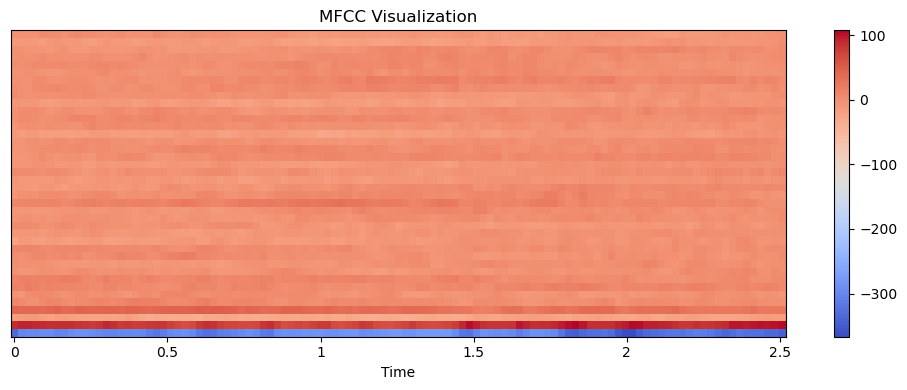

In [15]:
# Cell 14: Visualization — MFCC of One Sample
audio, sr = librosa.load(sample_file)
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.colorbar()
plt.title("MFCC Visualization")
plt.tight_layout()
plt.show()
